Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.

The project is CC-BY-NC licensed, as found in the LICENSE file of the github.

# Demo of image watermarking with Stable Signature's pre-trained HiDDeN model 

Clone repo:

In [ ]:
!git clone https://github.com/facebookresearch/stable_signature.git
%cd stable_signature/hidden

In [8]:
%cd stable_signature/hidden

/ssd-sata1/hqq/stable_signature/hidden


Install requirements:

In [13]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 870.0 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install scikit-image==0.20.0 and scipy==1.10.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested scipy==1.10.1
    scikit-image 0.20.0 depends on scipy<1.9.2 and >=1.8; python_version <= "3.9"

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [15]:
# Resolve issue in Augly library
!sudo apt-get install python3-magic

ERROR: Could not find a version that satisfies the requirement python3-magic (from versions: none)
ERROR: No matching distribution found for python3-magic


In [1]:
import os
import sys 
sys.path.append(os.getcwd())

!python models.py
!python attenuations.py

python: can't open file 'models.py': [Errno 2] No such file or directory
python: can't open file 'attenuations.py': [Errno 2] No such file or directory


Imports

In [2]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # you should run this notebook in the root directory of the hidden project for the following imports to work

# from models import HiddenEncoder, HiddenDecoder, EncoderWithJND, EncoderDecoder
# from attenuations import JND

/ssd-sata1/hqq/anaconda3/envs/stable_signature/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def msg2str(msg):
    return "".join([('1' if el else '0') for el in msg])

def str2msg(str):
    return [True if el=='1' else False for el in str]

### Load and build models 

The watermark signal can be rescaled with a factor `scaling_w`.

We use the just noticeable difference (JND) heatmap presented in https://github.com/facebookresearch/active_indexing to mask the watermark signal in areas where the eye is sensitive to changes.
This allows to impose perceptual constraint, in case we want to use the trained encoder to watermark images.

In [4]:
import models
import attenuations 

ModuleNotFoundError: No module named 'models'

In [ ]:
class Params():
    def __init__(self, encoder_depth:int, encoder_channels:int, decoder_depth:int, decoder_channels:int, num_bits:int,
                attenuation:str, scale_channels:bool, scaling_i:float, scaling_w:float):
        # encoder and decoder parameters
        self.encoder_depth = encoder_depth
        self.encoder_channels = encoder_channels
        self.decoder_depth = decoder_depth
        self.decoder_channels = decoder_channels
        self.num_bits = num_bits
        # attenuation parameters
        self.attenuation = attenuation
        self.scale_channels = scale_channels
        self.scaling_i = scaling_i
        self.scaling_w = scaling_w

NORMALIZE_IMAGENET = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
UNNORMALIZE_IMAGENET = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
default_transform = transforms.Compose([transforms.ToTensor(), NORMALIZE_IMAGENET])

params = Params(
    encoder_depth=4, encoder_channels=64, decoder_depth=8, decoder_channels=64, num_bits=48,
    attenuation="jnd", scale_channels=False, scaling_i=1, scaling_w=1.5
)

decoder = models.HiddenDecoder(
    num_blocks=params.decoder_depth, 
    num_bits=params.num_bits, 
    channels=params.decoder_channels
)
encoder = models.HiddenEncoder(
    num_blocks=params.encoder_depth, 
    num_bits=params.num_bits, 
    channels=params.encoder_channels
)
attenuation = attenuations.JND(preprocess=UNNORMALIZE_IMAGENET) if params.attenuation == "jnd" else None
encoder_with_jnd = models.EncoderWithJND(
    encoder, attenuation, params.scale_channels, params.scaling_i, params.scaling_w
)

In [ ]:
ckpt_path = "/ssd-sata1/hqq/stable_signature/hidden/output/output_bit/6/checkpoint.pth"

state_dict = torch.load(ckpt_path, map_location='cpu')['encoder_decoder']
encoder_decoder_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
encoder_state_dict = {k.replace('encoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'encoder' in k}
decoder_state_dict = {k.replace('decoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'decoder' in k}

encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

encoder_with_jnd = encoder_with_jnd.to(device).eval()
decoder = decoder.to(device).eval()

### Tests

PSNR: 38.313689820976535
Message: 011010110101001101010111010011010100010010101101
Decoded: 011010110101001101010111010011010100010010101101
Bit Accuracy: 1.0


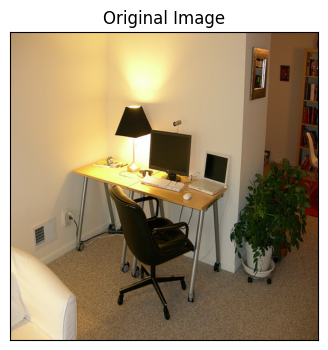

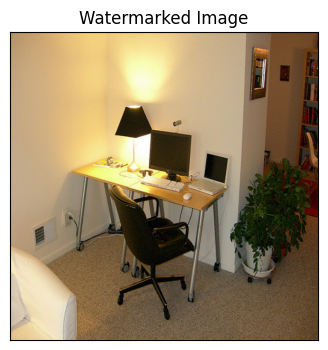

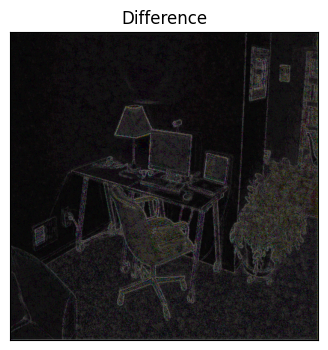

In [ ]:
# load image
img = Image.open("datasets/train_dir/000000037740.jpg").convert('RGB')
img = img.resize((512, 512), Image.BICUBIC)
img_pt = default_transform(img).unsqueeze(0).to(device)   ## 1*3*512*512

# create message
random_msg = False
if random_msg:
    msg_ori = torch.randint(0, 2, (1, params.num_bits), device=device).bool() # b k
else:
    msg_ori = torch.Tensor(str2msg("011010110101001101010111010011010100010010101101")).unsqueeze(0)
    # msg_ori = torch.Tensor(str2msg("111010110101000001010111010011010100010000100111")).unsqueeze(0)
msg = 2 * msg_ori.type(torch.float) - 1 # b k  ###将 0，1, 分别换成了 -1， 1
msg=msg.to(device)  ##这个是我加的  attention
msg_ori=msg_ori.to(device)

# encode
img_w = encoder_with_jnd(img_pt, msg)    ### encoder_with_jnd
clip_img = torch.clamp(UNNORMALIZE_IMAGENET(img_w), 0, 1)
clip_img = torch.round(255 * clip_img)/255 
clip_img = transforms.ToPILImage()(clip_img.squeeze(0).cpu())


# psnr
psnr = peak_signal_noise_ratio(np.array(img), np.array(clip_img))
print(f"PSNR: {psnr}")

import os 

i=3               ###子目录名称修改
path=os.path.join( "img_outputs" , str(i))
os.makedirs(path, exist_ok=True)

# plot
plt.figure(figsize=(4, 4))
plt.grid('off')
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.imshow(img)
path1=os.path.join(path,'ori_image.png')
plt.savefig(path1)

plt.figure(figsize=(4, 4))
plt.grid('off')
plt.xticks([])
plt.yticks([])
plt.title("Watermarked Image")
plt.imshow(clip_img)
path1=os.path.join(path,'w_image.png')
plt.savefig(path1) 


diff = np.abs(np.asarray(img).astype(int) - np.asarray(clip_img).astype(int)) / 255 * 10
plt.figure(figsize=(4, 4))
plt.grid('off')
plt.xticks([])
plt.yticks([])
plt.title("Difference")
plt.imshow(diff)
path1=os.path.join(path,'diff.png')
plt.savefig(path1) 

# decode
ft = decoder(default_transform(clip_img).unsqueeze(0).to(device))   ###decoder的预测结果 为一个个 浮点数
decoded_msg = ft > 0 # b k -> b k      ##根据正负值 分为0-1字符串
accs = (~torch.logical_xor(decoded_msg, msg_ori)) # b k -> b k
print(f"Message: {msg2str(msg_ori.squeeze(0).cpu().numpy())}")
print(f"Decoded: {msg2str(decoded_msg.squeeze(0).cpu().numpy())}")
print(f"Bit Accuracy: {accs.sum().item() / params.num_bits}")